# ENN583 Week 8 - Using PyTorch to train an Image Classifier

We will use this week's practical to become familiar with PyTorch, in particular how you to use the building blocks of deep learning with this library.

We will follow the deep learning "building blocks" that we discussed in the tutorial:
* Data:
  * Training, validation and test subsets
  * Data pre-processing
* Model:
  * creating an architecture
  * using convolutional layers, pooling layers, fully-connected linear layers, non-linear activation functions, and batch normalisation
* Training a model:
  * creating a loss function
  * creating a stochastic gradient descent (SGD) optimizer
  * using the optimizer and backpropagation to train the model parameters
* Evaluating a model:
  * accuracy performance metric

# 1. Load libraries


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np

import tqdm

# 2. The Data

The ```torchvision``` dataset has a number of [in-built datasets](https://pytorch.org/vision/main/datasets.html). These are very easy to load and work with.

One of this is a dataset called CIFAR10, which we are going to be performing image classification on. It has 10 classes: ‘airplane’, ‘automobile’, ‘bird’, ‘cat’, ‘deer’, ‘dog’, ‘frog’, ‘horse’, ‘ship’, ‘truck’. The images in CIFAR-10 are of size 3x32x32, i.e. 3-channel color images of 32x32 pixels in size.


In [27]:
class_labels = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

<img src="figures/cifar10.png" alt="cifar10" width="500"/>

Before we can load the dataset, we need to specify the necessary pre-processing that we're applying to the data. We do this with [transforms](https://pytorch.org/vision/0.9/transforms.html), which are a torchvision class.

Generally, there are always at least two image transforms we need to do:
* [convert the image into a Tensor](https://pytorch.org/vision/stable/generated/torchvision.transforms.ToTensor.html). A Tensor is the standard data type necessary for PyTorch, which represents multi-dimensional matrices
* [normalize the channels of the image by a mean and standard deviation](https://pytorch.org/vision/stable/generated/torchvision.transforms.Normalize.html#torchvision.transforms.Normalize). Each channel pixel values are standardized in the image tensors, which can be helpful for stabilizing the training of neural networks. Standard values are 0.5 for the mean and standard deviation.

With some datasets, we also need to resize images and apply other transformations.

In [2]:
basic_transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

### Now time to load the dataset!

Torchvision in-built datasets have 4 arguments that need to be included:
* ```root``` -- a string of where the data is stored
* ```train``` -- a boolean (True, False), that indicates whether it is the train or test subset of the dataset
* ```download``` -- a boolean (True, False), on whether the data should be downloaded
* ```transform``` -- the transformations that need to be applied to the data to make it suitable for a neural network.

In [3]:
train_dataset = torchvision.datasets.CIFAR10(root='data', train=True,
                                        download=True, transform=basic_transform)

val_dataset = torchvision.datasets.CIFAR10(root='data', train=False,
                                        download=True, transform=basic_transform)

Files already downloaded and verified
Files already downloaded and verified


### Using a Data Loader

In PyTorch, a ```DataLoader``` is a crucial component that streamlines data loading, making it easier to feed data into your deep learning models. Below are some of the key reasons why using a ```DataLoader``` is useful:

* **Batching**: Deep learning models often use mini-batch gradient descent or its variants (e.g., stochastic gradient descent, Adam) for optimization. DataLoader automatically groups the dataset into batches so that you can easily iterate over them during training.
* **Shuffling**: It's often beneficial to shuffle your training data to ensure the model does not memorize the data's order. DataLoader can automatically shuffle the data at each epoch.
* **Parallel data loading**: DataLoader enables parallel loading using multi-threading, which can significantly speed up the data pipeline.

**Your turn:**
Create a pytorch [dataloader](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) for the train_dataset and test_dataset, using the following parameters:
* both dataloaders should have a batch size of 64
* both dataloaders should use 2 workers to load the data (i.e. num_workers)
* trainloader should shuffle the data, testloader should not shuffle the data


In [4]:
######## Your code goes below ############


# 3. The Model: Create a Convolutional Neural Network

Below, we're creating a python class for a simple CNN that has 2 convolutional layers with Max pooling, followed by 2 fully-connected layers. We use ReLU activation functions. Try drawing the architecture of this diagram on paper.

You can read the documentation for the different layer types here:
* [nn.Conv2d](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html)
* [nn.MaxPool2d](https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html)
* [nn.Linear](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html)
* [nn.ReLU](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html)

The class definitions for a PyTorch model generally follow this minimum structure:
1. an **\__init__()** function where we create the model architecture.
2. a **foward()** function where we pass an input through our model and return its output.
    1. In the \__init__ function, we created the layers that make our architecture. Now we must apply them sequentially.



In [20]:
class SimpleNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 10)
        
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        
        x = torch.flatten(x, 1) # flatten all dimensions except batch to be compatible with fully connected layer

        x = self.fc1(x)
        x = self.fc2(self.relu(x))
        return x


Now that we've defined the network, let's create an instance of it. We're also *hopefully* using a GPU node at the moment, so we'll load the network onto the GPU if we are. If not, don't worry -- the network will stay on the CPU.

In [21]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu') #this line checks if we have a GPU available

#create network and load onto device
model = SimpleNet()
model.to(device)

print(model)
print(device)

SimpleNet(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=10, bias=True)
  (relu): ReLU()
)
cuda:0


# 4. Training the Model

## 4a). Defining the Loss function
One of the most standard loss functions for image classification is cross-entropy loss. PyTorch has an in-built function for this [loss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html), which we use below.

In [22]:
loss_fn = nn.CrossEntropyLoss()

## 4b). Defining the optimizer
Let's create a stochastic gradient descent optimizer. First, read the documentation [here](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html#torch.optim.SGD). 

There are a few important input arguments:
* params: we can initialise the optimizer to optimize the model parameters by pointing to ```model.parameters()```
* lr: this is the learning rate of the optimizer, or the step size during gradient descent
* momentum: this is an optional argument that often improves performance by smoothing out noise during gradient descent.
* weight_decay: this is an optional argument to regularize the weights with an L2 norm.

Below, we're creating an optimizer with a learning rate of 0.001 and momentum of 0.9.

In [23]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.005, momentum=0.9)

## 4c). Creating a training loop 

In the cell below, we're training the neural network (CNN) for 2 epochs. This should take about 1 minute if you're on the GPU, and about 2 minutes if you're on the CPU.

Notice the general flow of the training process:
1. For every epoch:
    1. We iterate through each batch in our trainloader
        1. We separate the inputs from the GT class labels
        2. Move inputs and GT labels to the GPU if available
        4. Zero the parameter gradients -- this is to ensure we start 'fresh' for each step of gradient descent.
        5. Forward pass through the network to find the prediction
        6. Calculate the loss between the prediction and GT labels
        7. Calculate the gradients with a backwards pass
        8. Change the parameters based on the gradients, using the optimizer
        9. Record any data we want to save
        
This is the general flow for the training process, with some important elements missing... before we get to that, run the training process, and observe the loss curve produced at the end.

Epoch 9: 100%|██████████| 782/782 [00:05<00:00, 138.95it/s]


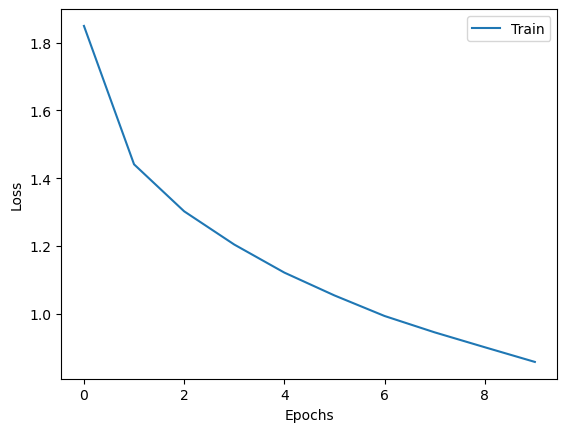

In [24]:
losses = {'train': []}
total_epochs = 10

for epoch in range(total_epochs):    
    train_loss = []
    
    for i, data in tqdm.tqdm(enumerate(trainloader, 0), total = len(trainloader), desc = f'Epoch {epoch}'):
        inputs, labels = data
        
        #move the inputs and labels to the GPU if available
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward pass to find the outputs
        outputs = model(inputs)
        
        #calculate the loss
        loss = loss_fn(outputs, labels)
        
        #backward pass to calculate the gradient
        loss.backward()
        
        #take a step with gradient descent to change the parameters
        optimizer.step()

        #let's keep track of the loss
        train_loss += [loss.cpu().item()]

    #record the mean loss over the entire epoch
    epoch_loss = np.mean(train_loss)
    losses['train'] += [epoch_loss]
    
#let's plot the loss for each epoch to observe how it changes over 10 epochs
plt.plot(losses['train'], label = 'Train')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Your turn!
There are a number of key elements missing from the cell above. I've pasted the same code below. One-by-one, add each of these elements to the below cell.

1. The loss itself is not very interpretable. Create another plot that shows the average accuracy on the training data at each epoch.
    1. You will need to find the predicted class by using the maximum class score in outputs for each input. The torch.argmax() function will be useful.
    2. You will need to compare the predicted class to the GT labels stored in the labels variable.
2. Comparison to the validation dataset in each epoch.
    1. After the loop that tests the trainloader, add a loop that tests the valloader.
    **It is critical that you do not perform a backward pass of optimizer step on the validation data. We do not want to learn from the validation data, only measure performance.**
    2. Store the loss and accuracy for the validation data, and plot it on the same plots as the training datasets.

**NOTE:** When you want to train the model, you should enter 'training' mode by calling ```model.train()```. When you want to evaluate your model, you should enter 'eval' mode by calling ```model.eval()```.

After you've done the above, consider: At what point has the model converged?
 

Epoch 9: 100%|██████████| 782/782 [00:05<00:00, 136.98it/s]


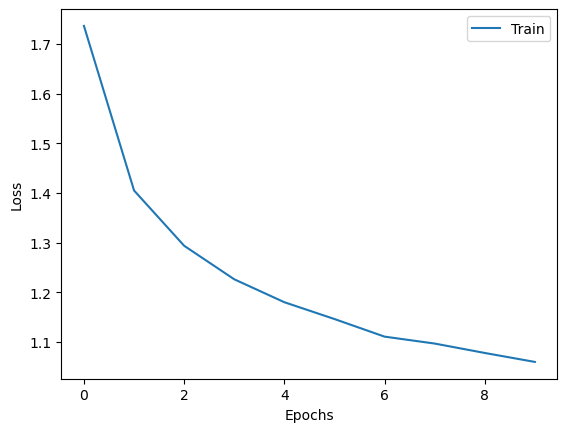

In [19]:
####UPDATE THE CODE BELOW
model = SimpleNet()
model.to(device)

loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(model.parameters(), lr=0.005, momentum=0.9)

losses = {'train': []}
total_epochs = 10

for epoch in range(total_epochs):    
    train_loss = []
    
    for i, data in tqdm.tqdm(enumerate(trainloader, 0), total = len(trainloader), desc = f'Epoch {epoch}'):
        inputs, labels = data
        
        #move the inputs and labels to the GPU if available
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward pass to find the outputs
        outputs = model(inputs)
        
        #calculate the loss
        loss = loss_fn(outputs, labels)
        
        #backward pass to calculate the gradient
        loss.backward()
        
        #take a step with gradient descent to change the parameters
        optimizer.step()

        #let's keep track of the loss
        train_loss += [loss.cpu().item()]

    #record the mean loss over the entire epoch
    epoch_loss = np.mean(train_loss)
    losses['train'] += [epoch_loss]
    
#let's plot the loss for each epoch to observe how it changes over 10 epochs
plt.plot(losses['train'], label = 'Train')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Further Exploration
There are a number of remaining areas to explore. Depending on how you're going for time, pick one or try them all!

## 1. Data Augmentation

There are a couple of things that can help with overfitting -- one would be adding some data transformations. Go through the additional data transformation functions below, and choose some additional transforms to apply. Remember to tailor the transformations to the characteristics the dataset (e.g. does it make sense to rotate the image 180 degrees?). We also only apply data augmentation to the training set, while the validation and test sets will use the standard transform that does not include data augmentation.

**Your turn: Pick additional data transforms and add create a train_transforms list, then re-load the train dataset and see how this affects performance!**

1. (already implemented below) [transforms.RandomResizedCrop](https://pytorch.org/vision/stable/generated/torchvision.transforms.RandomResizedCrop.html) -- this function randomly grabs a portion of the image (crops) and then resizes to the desired image size. By default, the crop can be anywhere between 8% to 100% of the image original area -- this is a little strict, I'm going to choose between 50% and 100% of the image area.
2. [transforms.RandomHorizontalFlip](https://pytorch.org/vision/stable/generated/torchvision.transforms.RandomHorizontalFlip.html) -- randomly flips an image horizontally. Useful for tasks where horizontal orientation doesn't change the meaning.
3. [transforms.RandomVerticalFlip](https://pytorch.org/vision/stable/generated/torchvision.transforms.RandomVerticalFlip.html) -- randomly flips an image vertically. Useful for tasks where vertical orientation doesn't change the meaning.
4. [transforms.RandomRotation](https://pytorch.org/vision/stable/generated/torchvision.transforms.RandomRotation.html) -- randomly rotates an image by a specified angle. Can simulate variations in viewpoint.
5. [transforms.ColorJitter](https://pytorch.org/vision/stable/generated/torchvision.transforms.ColorJitter.html) -- randomly changes brightness, contrast, saturation, and hue of an image. Helps the model to be robust to different lighting conditions.

Once we've done this, you can re-initialise the training dataset with this transform.

**What's going on here?**

Each of the 'Random' transformations will be sequentially applied to an input image, with different transformations of different severities - the severity of the transformation is the random component. When you chain together multiple different types of 'Random' transformations, we can end up with a huge variation of different images from our training dataset.


In [30]:
#### Insert code here to create a new transform for the training data, re-initialise the train_dataset with these transforms, and re-create the trainloader

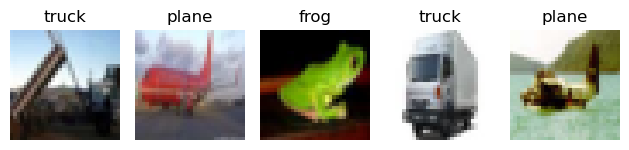

In [29]:
#use this function to visualise the train dataset with these transforms once you've re-created the trainloader
data = next(iter(trainloader))
fig, ax = plt.subplots(1, 5)
for idx in range(5):
    im = data[0][idx]
    lbl = data[1][idx]
    train_image = (im.numpy())/2 + 0.5
    label = class_labels[lbl]
    train_image = np.moveaxis(train_image, 0, 2)
    ax[idx].imshow(train_image)
    ax[idx].set_axis_off()
    ax[idx].set_title(label.split('-')[-1])
plt.tight_layout()
plt.show()


## 2. Batch Normalization

Another type of layer that is very popular in modern deep learning is the batch normalisation layer -- you can read the Pytorch documentation [here](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html#torch.nn.BatchNorm2d). Try creating 2 batch norm layers that immediately proceed the convolutional layers in the network. 

After you've added this to the model definition, re-train your network. Do you observe any change in performance?


In [31]:
### Adapt the code from earlier to include batch normalisation layers in your model

## 3. Observing Model Confidence

The outputs from the model are currently un-normalised class logits (scores for each class, but not a distribution between 0 and 100%). 

You can apply a [Softmax function](https://pytorch.org/docs/stable/generated/torch.nn.functional.softmax.html) to the outputs from your model to find the pseudo-confidence scores in a prediction. Try visualising what the confidence score is for correct predictions and incorrect predictions -- does the model seem to give a higher confidence for correct predictions and lower confidence for incorrect predictions?

In [32]:
### Adapt the code from earlier to observe model confidence in predictions